In [1]:
#Import needed packages

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_curve
from sklearn import metrics

from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV, KFold


In [2]:
#load preprocessed data
mrna_x = pd.read_csv('zscore.csv')
mrna_x.drop(columns=mrna_x.columns[0], axis=1, inplace=True)
#mrna_x.drop('target', axis=1, inplace=True)
y = np.load('processed_recurrence_data_zscore.npy')
selector = VarianceThreshold(0.2)
vars = selector.fit_transform(mrna_x)
print(vars.shape)
print(mrna_x.shape)
X_train, X_test, y_train, y_test = train_test_split(mrna_x.values, y,
                                                    train_size=0.75, test_size=0.25)

age = np.load('age_data.npy')
gender = np.load('gender_data.npy')
stage = np.load('stage_data.npy')

# Try using lasso (feature selection), feature importance, shap


c:\Python39\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Python39\lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Python39\lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Python39\lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.appl

(435, 19212)
(435, 19910)


In [3]:
print(X_train.shape)
print(mrna_x.values.shape)

(326, 19910)
(435, 19910)


In [4]:
print(mrna_x.values)

[[-3.0863 -0.5997  1.5294 ... -1.2508  0.1191 -1.1115]
 [-3.0863 -0.8006 -0.8942 ...  1.245   2.0039 -1.1115]
 [-3.0863 -0.5059  0.9541 ...  1.3399 -0.7256 -1.1115]
 ...
 [-3.0863 -0.6972  1.0341 ... -0.8519  2.6883 -1.1115]
 [-3.0863  1.187   0.9998 ... -1.3052 -0.4012 -1.1115]
 [-3.0863 -0.3087  1.2304 ... -1.2832  1.9043 -1.1115]]


In [5]:
# parameters to be tested on GridSearchCV
params = {"alpha":np.arange(0.00001, 10, 500)}

# Number of Folds and adding the random state for replication
kf=KFold(n_splits=5,shuffle=True, random_state=42)

# Initializing the Model
lasso = Lasso()

# GridSearchCV with model, params and folds.
lasso_cv=GridSearchCV(lasso, param_grid=params, cv=kf)
lasso_cv.fit(mrna_x.values, y)
print("Best Params {}".format(lasso_cv.best_params_))

c:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.175e-02, tolerance: 7.126e-03
  model = cd_fast.enet_coordinate_descent(
c:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.211e-02, tolerance: 7.169e-03
  model = cd_fast.enet_coordinate_descent(
c:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.261e-02, tolerance: 7.210e-03
  model = cd_fast.enet_coo

Best Params {'alpha': 1e-05}


c:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.023e-02, tolerance: 8.950e-03
  model = cd_fast.enet_coordinate_descent(


In [6]:
names=mrna_x.columns
print("Column Names: {}".format(names.values))
print(len(names))

Column Names: ['LOC100130426' 'UBE2Q2P3' 'UBE2Q2P3.1' ... 'ZZZ3' 'TPTEP1' 'AKR1C6P']
19910


In [7]:
# calling the model with the best parameter
lasso1 = Lasso(alpha=0.00001)
lasso1.fit(X_train, y_train)

# Using np.abs() to make coefficients positive.  
lasso1_coef = np.abs(lasso1.coef_)




c:\Python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.014e-02, tolerance: 6.773e-03
  model = cd_fast.enet_coordinate_descent(


In [8]:
feature_subset=np.array(names)[lasso1_coef>0.001]
print("Selected Feature Columns: {}".format(feature_subset))
print(len(feature_subset))

lasso_x = mrna_x[feature_subset]
print(lasso_x.shape)

lasso_x['Age'] = age
lasso_x['Gender'] = gender
lasso_x['Stage'] = stage

X_train, X_test, y_train, y_test = train_test_split(lasso_x.values, y,
                                                    train_size=0.75, test_size=0.25, shuffle=True, random_state=123)

Selected Feature Columns: ['LOC100130426' 'UBE2Q2P3' 'UBE2Q2P3.1' ... 'VWDE' 'WNK2' 'ZNF880']
1317
(435, 1317)


C:\Users\nitin\AppData\Local\Temp\ipykernel_14912\241295037.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lasso_x['Age'] = age
C:\Users\nitin\AppData\Local\Temp\ipykernel_14912\241295037.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lasso_x['Gender'] = gender
C:\Users\nitin\AppData\Local\Temp\ipykernel_14912\241295037.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

In [9]:
lasso_x

,LOC100130426,UBE2Q2P3,UBE2Q2P3.1,TIMM23,LOC155060,SSX9,EZHIP,EFCAB8,LOC391343,TRIM75P,...,UBQLN3,UOX,UPK1B,USP17L6P,VWDE,WNK2,ZNF880,Age,Gender,Stage
0,-3.0863,-0.5997,1.5294,-0.5550,-0.0905,-0.9372,-1.5927,-1.5707,-1.3357,-1.3125,...,-2.4209,0.0421,-0.2065,-3.4933,-0.9194,-0.0496,0.1502,69,0,0
1,-3.0863,-0.8006,-0.8942,1.8552,0.1934,-0.9372,-0.5358,-0.1335,-1.3357,-1.3125,...,-0.1208,-1.9378,0.1588,-3.4933,-0.9601,0.6042,-1.1109,68,1,0
2,-3.0863,-0.5059,0.9541,-0.3691,0.0083,-0.9372,-0.5668,-1.5707,-1.3357,-1.3125,...,-2.4209,-1.9378,-1.4314,-3.4933,-1.2773,-0.9105,-1.8695,67,0,0
3,-3.0863,-1.0747,-0.1385,-0.6454,-0.0301,-0.9372,0.1283,-0.2927,-0.4525,0.5771,...,-2.4209,1.5813,-1.4314,-3.4933,-0.9998,0.3500,-1.2717,66,0,2
4,-3.0863,0.3223,-0.7343,0.1476,0.9885,-0.9372,0.6324,5.0700,-1.3357,-1.3125,...,-2.4209,2.2995,-0.9899,-3.4933,0.9511,0.7472,1.2509,77,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430,-3.0863,0.0191,-0.3816,-0.1537,1.4572,-0.9372,-0.5883,0.2341,-1.3357,-1.3125,...,-2.4209,-1.9378,0.1922,-3.4933,-0.6016,0.7954,-1.5095,41,0,4
431,-3.0863,1.6135,-0.6012,-0.1316,2.2147,-0.9372,1.7922,0.5098,-1.3357,-0.2478,...,0.1781,1.3724,-1.4314,-3.4933,-1.2773,0.7324,0.3330,68,0,1
432,-3.0863,-0.6972,1.0341,1.7282,0.8359,-0.9372,0.1106,0.7454,-1.3357,-1.3125,...,-2.4209,-1.9378,-0.2561,-3.4933,-0.7226,0.1149,-0.7365,58,1,0
433,-3.0863,1.1870,0.9998,-0.4700,0.5836,-0.9372,-1.5927,-1.5707,-1.3357,-1.3125,...,-2.4209,-1.9378,-0.1967,-3.4933,-1.0247,-1.0015,-1.0477,72,1,0


In [10]:
X_train_full, X_test_full, y_train, y_test = train_test_split(mrna_x.values, y,
                                                    train_size=0.75, test_size=0.25, shuffle=True, random_state=123)

In [11]:
pos_x_train = []
neg_x_train = []
print(type(X_train))
for i in range(len(X_train)):
    if y_train[i] == 1:
        pos_x_train.append(X_train[i])
    else:
        neg_x_train.append(X_train[i])
pos_x_train = np.array(pos_x_train)
neg_x_train = np.array(neg_x_train)


<class 'numpy.ndarray'>


In [12]:
batches = []
batches_y = []

num_batches = 50

batch_size = 32

c = 0
for i in range(num_batches):
    batch = []
    batch_y = []
    temp = np.random.permutation(len(pos_x_train))[:int(batch_size/2)]
    for t in temp:
        batch.append(pos_x_train[t])
        batch_y.append(1)
    temp = np.random.permutation(len(neg_x_train))[:int(batch_size/2)]
    for t in temp:
        batch.append(neg_x_train[t])
        batch_y.append(0)
    batch = np.array(batch)
    batches.append(batch)
    batch_y = np.array(batch_y)
    batches_y.append(batch_y)



In [13]:
pos=sum(y)
total = len(y)
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 435
    Positive: 126 (28.97% of total)



In [14]:
#make and compile the Neural Network model

'''
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(200, input_shape=(20531,),activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.relu),
  tf.keras.layers.Dense(2, activation='softmax')

])

model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                      optimizer = tf.keras.optimizers.Adam(), metrics=['accuracy'])

'''
x = lasso_x.shape[1]

model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(x, input_shape=(x,),activation=tf.nn.relu),
  tf.keras.layers.Dense(int(x/2), activation=tf.nn.relu),
  tf.keras.layers.Dense(1, activation='sigmoid')

])

model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics=['accuracy', tf.keras.metrics.BinaryCrossentropy()])

In [15]:
lasso_x.shape[1]

1320

In [16]:
weights = {}
num_samples = len(y_train)
pos_count = sum(y_train)
neg_count =  num_samples - pos_count

weights[0] = num_samples / (2 * neg_count)
weights[1] = num_samples / (2 * pos_count)


print(weights, num_samples, pos_count, neg_count)

{0: 0.7180616740088106, 1: 1.6464646464646464} 326 99 227


In [17]:
#Train the model on the cBioPortal data

es = tf.keras.callbacks.EarlyStopping (monitor='val_loss', restore_best_weights=True, patience=3)

model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test), class_weight = weights, callbacks=[es])


Epoch 1/100


11/11 [==============================] - 1s 41ms/step - loss: 2.2624 - accuracy: 0.6104 - binary_crossentropy: 2.2967 - val_loss: 1.2512 - val_accuracy: 0.6239 - val_binary_crossentropy: 1.2512
Epoch 2/100
11/11 [==============================] - 0s 15ms/step - loss: 0.4645 - accuracy: 0.8374 - binary_crossentropy: 0.4104 - val_loss: 0.6452 - val_accuracy: 0.7156 - val_binary_crossentropy: 0.6452
Epoch 3/100
11/11 [==============================] - 0s 15ms/step - loss: 0.2436 - accuracy: 0.9049 - binary_crossentropy: 0.2509 - val_loss: 0.5057 - val_accuracy: 0.8073 - val_binary_crossentropy: 0.5057
Epoch 4/100
11/11 [==============================] - 0s 28ms/step - loss: 0.1087 - accuracy: 0.9663 - binary_crossentropy: 0.1184 - val_loss: 0.5177 - val_accuracy: 0.8073 - val_binary_crossentropy: 0.5177
Epoch 5/100
11/11 [==============================] - 0s 17ms/step - loss: 0.0305 - accuracy: 1.0000 - binary_crossentropy: 0.0309 - val_loss: 0.5350 - val_accuracy: 0.8073 - 

In [18]:
#Validate the model

model.evaluate(X_test, y_test, verbose=2)

4/4 - 0s - loss: 0.5057 - accuracy: 0.8073 - binary_crossentropy: 0.5057 - 48ms/epoch - 12ms/step


[0.5057425498962402, 0.8073394298553467, 0.5057425498962402]

In [19]:
#print(model.predict(X_test))
print(X_test)
print(y_test)

[[-3.0863  1.2855  0.1118 ... 79.      0.      0.    ]
 [-3.0863 -2.6026 -0.1031 ... 49.      0.      2.    ]
 [-3.0863 -0.1705  0.7583 ... 61.      0.      1.    ]
 ...
 [-3.0863 -1.6232 -0.1132 ... 54.      1.      1.    ]
 [-3.0863 -1.1919 -1.2948 ... 59.      0.      2.    ]
 [-3.0863 -1.2865 -0.1928 ... 40.      0.      0.    ]]
[0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 0 0]


In [20]:
y_prob_tf = model.predict(X_test)

4/4 [==============================] - 0s 3ms/step


In [21]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C = 1000, max_iter=2000, penalty='l1', solver='liblinear', random_state=123)
lr.fit(X_train, y_train)
print(lr.score(X_test, y_test))
y_prob_lr = lr.predict_proba(X_test)[:,1]

0.8532110091743119


In [22]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(max_depth = 15)
rf.fit(X_train, y_train)
print(rf.score(X_test, y_test))
y_prob_rf = rf.predict_proba(X_test)[:,1]

0.7431192660550459


In [23]:
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(num_leaves = 3, verbose=0)
lgb.fit(X_train_full, y_train)
print(lgb.score(X_test_full, y_test))
y_prob_lgb = lgb.predict_proba(X_test_full)[:,1]

0.7431192660550459


In [24]:
from sklearn.svm import SVC
svc = SVC(probability=True, C=1000, kernel='linear')
svc.fit(X_train, y_train)
print(svc.score(X_test, y_test))
y_prob_svc = svc.predict_proba(X_test)[:,1]

0.8440366972477065


In [25]:
from sklearn.neighbors import KNeighborsClassifier

kn = KNeighborsClassifier()
kn.fit(X_train, y_train)
print(kn.score(X_test, y_test))
y_prob_kn = kn.predict_proba(X_test)[:,1]



0.7247706422018348


In [26]:
from sklearn.ensemble import AdaBoostClassifier

adb = AdaBoostClassifier(random_state=123)
adb.fit(X_train, y_train)
print(adb.score(X_test, y_test))
y_prob_adb = adb.predict_proba(X_test)[:,1]

0.7247706422018348


In [27]:
from sklearn.naive_bayes import BernoulliNB

bnb = BernoulliNB()
bnb.fit(X_train, y_train)
print(bnb.score(X_test, y_test))
y_prob_bnb = bnb.predict_proba(X_test)[:,1]


0.7431192660550459


In [28]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(random_state=123)
mlp.fit(X_train, y_train)
print(mlp.score(X_test, y_test))
y_prob_mlp = mlp.predict_proba(X_test)[:,1]

0.8165137614678899


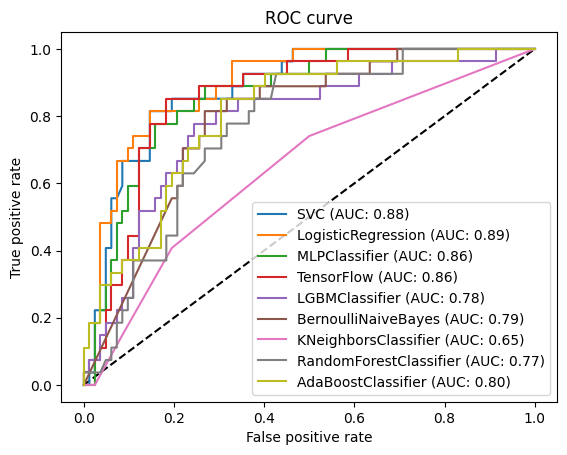

In [29]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')

fpr, tpr, thresholds = roc_curve(y_test, y_prob_svc)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='SVC (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_lr)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='LogisticRegression (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_mlp)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='MLPClassifier (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_tf)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='TensorFlow (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_lgb)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='LGBMClassifier (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_bnb)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='BernoulliNaiveBayes (AUC: {:.2f})'.format(auc_val))


fpr, tpr, thresholds = roc_curve(y_test, y_prob_kn)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='KNeighborsClassifier (AUC: {:.2f})'.format(auc_val))

fpr, tpr, thresholds = roc_curve(y_test, y_prob_rf)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='RandomForestClassifier (AUC: {:.2f})'.format(auc_val))



fpr, tpr, thresholds = roc_curve(y_test, y_prob_adb)
auc_val = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='AdaBoostClassifier (AUC: {:.2f})'.format(auc_val))




plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
